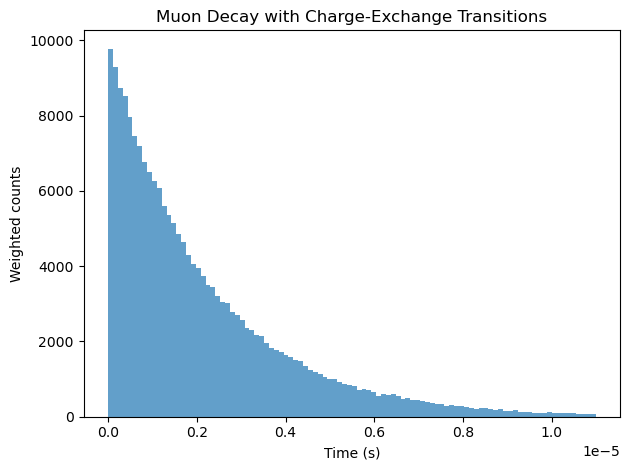

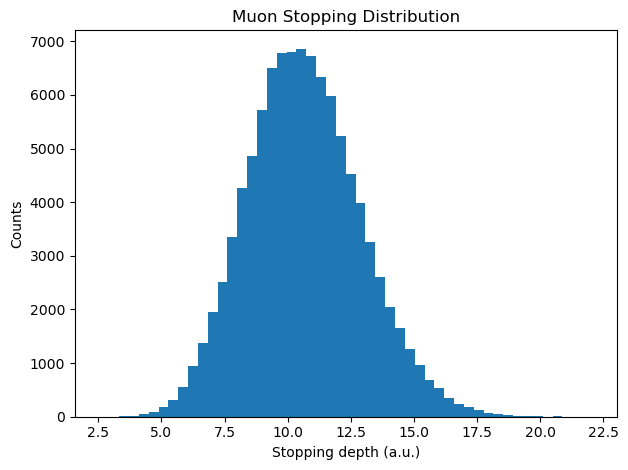

In [2]:
'''
Muon Decay & Muonium State Transition Simulation
------------------------------------------------
This Python module extends a basic muon decay Monte Carlo to include:

1. **Muon decay times** via inverse-transform sampling (exponential distribution).
2. **Charge-exchange transitions** between Mu⁰_BC and Mu⁺_BC states using the Senba time-ordered stochastic method:
   - Electron capture (Mu⁺ → Mu⁰) at rate ν_c
   - Thermal ionization & hole capture (Mu⁰ → Mu⁺) at rate ν_I
   - Poissonian waiting times for each process
3. **Spin phase evolution** through sequential segments, accumulating φ = ∑ ω_i Δt
4. **Decay histogramming** with asymmetry weighting (1 + A·cosφ)
5. **Basic beam/instrument Monte Carlo** skeleton for muon initial sampling & stopping-position histogram

Dependencies:
- numpy
- matplotlib

Usage:
    python muon_decay_simulation.py
'''
import numpy as np
import matplotlib.pyplot as plt

# Physical constants and defaults
MUON_LIFETIME = 2.1969811e-6        # Mean lifetime of muon in seconds
ASYMMETRY_A = 0.27                  # Decay asymmetry factor
BEXT = 0.1                          # Magnetic field in Tesla
OMEGA_FREE = 2 * np.pi * 135.5e6    # Free muon Larmor frequency in rad/s

# Charge-exchange rates
NU_C = 1e6      # Rate of electron capture (Mu⁺ → Mu⁰) in s⁻¹
NU_I = 1e5      # Rate of ionization (Mu⁰ → Mu⁺) in s⁻¹

# Mu⁰_BC precession frequencies and corresponding amplitudes
MU0_FREQS = [0.9 * OMEGA_FREE, 1.1 * OMEGA_FREE]  # Simulated precession frequencies
MU0_AMPLITUDES = [0.47, 0.26]                     # Relative probabilities of frequencies

class MuonTransitionSimulator:
    def __init__(self, tau=MUON_LIFETIME, nu_c=NU_C, nu_i=NU_I,
                 freqs=MU0_FREQS, amps=MU0_AMPLITUDES, asym=ASYMMETRY_A):
        # Initialize simulation parameters
        self.tau = tau
        self.nu_c = nu_c
        self.nu_i = nu_i
        self.freqs = np.array(freqs)
        self.amps = np.array(amps) / np.sum(amps)  # Normalize amplitudes
        self.asym = asym

    def sample_waiting(self, rate):
        # Sample waiting time from exponential distribution
        return -np.log(np.random.rand()) / rate

    def choose_next_process(self):
        # Randomly decide between capture and ionization based on relative rates
        p_c = self.nu_c / (self.nu_c + self.nu_i)
        return 'capture' if np.random.rand() < p_c else 'ionization'

    def simulate_decay_event(self):
        # Simulate the full decay process with state transitions and phase accumulation

        t_decay = self.sample_waiting(1.0 / self.tau)  # Decay time from exponential distribution
        state = 'MuPlus'  # Start in Mu⁺ state
        t = 0.0
        phi = 0.0  # Spin phase accumulator

        while True:
            # Determine time until next state transition
            total_rate = self.nu_c + self.nu_i
            dt = self.sample_waiting(total_rate)

            if t + dt >= t_decay:
                # If muon decays before the next transition, adjust dt to remaining time
                dt = t_decay - t
                # Accumulate final segment of phase based on current state
                if state == 'MuZero':
                    omega = np.random.choice(self.freqs, p=self.amps)
                else:
                    omega = OMEGA_FREE
                phi += omega * dt
                break

            # Accumulate spin phase during this segment
            if state == 'MuZero':
                omega = np.random.choice(self.freqs, p=self.amps)
            else:
                omega = OMEGA_FREE
            phi += omega * dt
            t += dt

            # Perform charge-exchange transition
            proc = self.choose_next_process()
            state = 'MuZero' if proc == 'capture' else 'MuPlus'

        return t_decay, phi

    def build_histogram(self, N, t_max=None, bins=200):
        # Simulate N muon events and build histogram of decay times with asymmetry weighting
        times = []
        weights = []
        for _ in range(N):
            t_d, phi = self.simulate_decay_event()
            times.append(t_d)
            # Weight based on asymmetry and spin phase
            weights.append(1 + self.asym * np.cos(phi))

        # Define time range if not provided
        if t_max is None:
            t_max = 5 * self.tau

        # Create histogram of decay times
        counts, edges = np.histogram(times, bins=bins, range=(0, t_max), weights=weights)
        centers = 0.5 * (edges[:-1] + edges[1:])  # Compute bin centers
        return centers, counts

class MuonBeamSimulator:
    def __init__(self, energy_dist=None, angle_dist=None):
        # Initialize beam distributions or use default normal distributions
        self.energy_dist = energy_dist or (lambda: np.random.normal(4e6, 0.5e6))  # Muon energy in eV
        self.angle_dist = angle_dist or (lambda: np.random.normal(0, 0.01))       # Beam angle in radians

    def simulate_beam(self, N):
        # Simulate stopping depths for N muons based on energy and angle
        points = []
        for _ in range(N):
            E = self.energy_dist()  # Sample energy
            theta = self.angle_dist()  # Sample angle
            # Approximate stopping depth as a function of energy and angle
            depth = (E * 1e-6)**1.7 * np.cos(theta)
            points.append(depth)
        return np.array(points)

    def plot_stopping_histogram(self, depths, bins=50):
        # Plot histogram of simulated muon stopping depths
        plt.figure()
        plt.hist(depths, bins=bins)
        plt.xlabel('Stopping depth (a.u.)')
        plt.ylabel('Counts')
        plt.title('Muon Stopping Distribution')
        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    # Run simulation of muon transitions and build histogram
    sim = MuonTransitionSimulator()
    centers, counts = sim.build_histogram(N=200_000, bins=100)

    # Plot decay histogram
    plt.figure()
    plt.bar(centers, counts, width=centers[1]-centers[0], alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Weighted counts')
    plt.title('Muon Decay with Charge-Exchange Transitions')
    plt.tight_layout()
    plt.show()

    # Run and plot beam stopping depth simulation
    beam = MuonBeamSimulator()
    depths = beam.simulate_beam(100_000)
    beam.plot_stopping_histogram(depths)
